In [1]:
from sophius.modelgen import ConvModelGenerator
from sophius.utils import calc_model_flops
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

In [6]:
from sophius.db import *
from peewee import *
import pandas as pd

query = (Runs
         .select(Runs.id.alias('run_id'), Runs, Models, Devices.name.alias('dev_name'))
         .where(Runs.exp_id==1)
         .join(Models)
         .switch(Runs)
         .join(Devices)
         .dicts())

cols = ['run_id', 'hash', 'flops', 'params', 'val_acc', 'train_acc', 'time', 'dev_name']
df = pd.DataFrame(query)[cols]
df.time = df.time.round()

# df = pd.DataFrame(query)

df

,run_id,hash,flops,params,val_acc,train_acc,time,dev_name
0,1,0080810a080800000049200001000000,2053728,145642,0.663141,0.865986,14.0,NVIDIA GeForce RTX 4090
1,2,00880406200000000024a80001000000,30624,954,0.399900,0.405278,14.0,NVIDIA GeForce RTX 4090
2,3,0080804520000000400000000023300001000000,1437216,29770,0.642238,0.700962,14.0,NVIDIA GeForce RTX 4090
3,4,0080421210080000400000000010000001000000,3738752,7818,0.479167,0.488632,17.0,NVIDIA GeForce RTX 4090
4,5,008402112000000000485000400000000010000001000000,357920,986,0.436639,0.439653,18.0,NVIDIA GeForce RTX 4090
...,...,...,...,...,...,...,...,...
8840,8851,0080421220000000004520000022d00000810222100400...,43234176,757962,0.763121,0.999700,113.0,Quadro RTX 6000
8841,8852,00840422100400000042a0000024d00000804822100800...,84006928,555403,0.733624,0.995483,85.0,Quadro RTX 6000
8842,8853,008020a2080400000044900000808821100800000024c8...,79741856,252011,0.663401,0.696815,160.0,Quadro RTX 6000
8843,8854,0088082120000000004910000081012108040000004510...,33437848,408883,0.710857,0.959315,127.0,Quadro RTX 6000


In [43]:
df['len'] = df.hash.apply(len)
df.sort_values(by=['len', 'val_acc'], ascending=[True, False])

,run_id,hash,flops,params,val_acc,train_acc,time,dev_name,len
530,531,008042110804000001000000,3398400,294283,0.644401,0.950270,17.0,NVIDIA GeForce RTX 4090,24
864,865,0080810a0804000001000000,1997952,123467,0.641236,0.885106,15.0,NVIDIA GeForce RTX 4090,24
442,443,0080204a0808000001000000,7341312,260938,0.639073,0.965986,14.0,NVIDIA GeForce RTX 4090,24
1006,1007,008020850804000001000000,2239104,115019,0.636889,0.882021,14.0,NVIDIA GeForce RTX 4090,24
3841,3842,008021110808000001000000,6472704,391114,0.636609,0.974419,15.0,NVIDIA GeForce RTX 4090,24
...,...,...,...,...,...,...,...,...,...
8278,8279,00820061080400004000000000292800008080a1080800...,385514136,1023284,0.737710,0.969852,172.0,NVIDIA GeForce RTX 4090,288
4719,4720,0082010908080000004510004000000000292800008401...,1382664,402453,0.616687,0.694151,79.0,NVIDIA GeForce RTX 4090,296
2186,2187,00841012080400000042a0004000000000810212100400...,1580960,375563,0.540835,0.627955,79.0,NVIDIA GeForce RTX 4090,296
3134,3135,0080281120000000400000000023300000804811080800...,18741728,1270323,0.666747,0.970292,87.0,NVIDIA GeForce RTX 4090,320


In [133]:
from sophius.encode import Encoder

encoder = Encoder()
encoder.hash2model('00802221200000000042a00001000000', (3, 32, 32), 10)

Conv2d       (192, 29, 29)  (4, 4)   (1, 1)  
ReLU         (192, 29, 29) 
MaxPool2d    (192, 15, 15)  (4, 4)   (2, 2)  
Flatten      43200         
Linear       10            

In [80]:
from sophius.modelgen import ConvModelGenerator
model_gen = ConvModelGenerator((3, 32, 32), 10, conv_num=1, lin_num=1)
t = model_gen.generate_model_tmpl()
print(t)
encoder.model2hash(t)

Conv2d       (16, 11, 11)   (7, 7)   (3, 3)  
PReLU        (16, 11, 11)  
MaxPool2d    (16, 3, 3)     (3, 3)   (3, 3)  
BatchNorm2d  (16, 3, 3)    
Flatten      144           
Linear       10            



'0084004a08080000004450004000000001000000'

In [121]:
import torch
from sophius.estimate import LSTMRegressor
from sophius.utils import calc_model_flops

estimator = torch.load('../data/models/estimator_v2.pth').cpu()
estimator.eval()

def estimate_acc(model_tmpl):
    t = torch.tensor(encoder.model2vec(model_tmpl), dtype=torch.float32)
    return estimator(t).item()

In [132]:
from sophius.templates import Conv2dTmpl, ReLUTmpl, GlobalAvgPool2dTmpl, LinearTmpl, ModelTmpl, FlattenTmpl, \
    MaxPool2dTmpl, PReLUTmpl, BatchNorm2dTmpl
from sophius.utils import calc_model_flops

templates = [
    Conv2dTmpl(out_channels=192, kernel_size=(4, 4), stride=(1, 1), padding=False),
    PReLUTmpl(),
    MaxPool2dTmpl(kernel_size=(3, 3), stride=(3, 3), padding=True),
    BatchNorm2dTmpl(),
    FlattenTmpl(),
    LinearTmpl(),
]

t = ModelTmpl((3, 32, 32), 10, *templates)
print(t)
print(calc_model_flops(t.instantiate_model(), t.in_shape))
print('val_acc*', round(estimate_acc(t), 3))

Conv2d       (192, 29, 29)  (4, 4)   (1, 1)  
PReLU        (192, 29, 29) 
MaxPool2d    (192, 10, 10)  (3, 3)   (3, 3)  
BatchNorm2d  (192, 10, 10) 
Flatten      19200         
Linear       10            

{'flops': 16408128, 'macs': 7942656, 'params': 201994}
val_acc* 0.657


In [139]:
df['pred_val_acc'] = df.hash.apply(encoder.hash2model, in_shape=(3, 32, 32), out_shape=10).apply(estimate_acc)

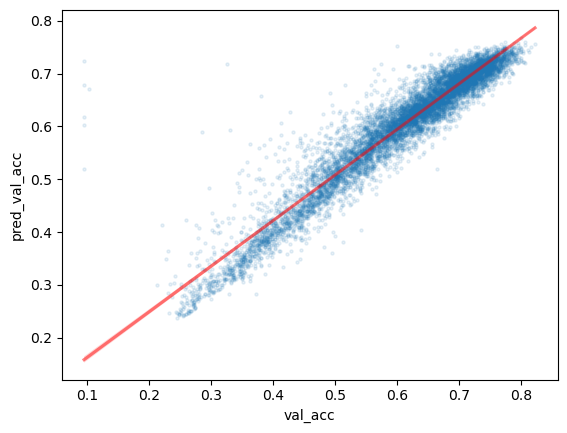

In [146]:
import seaborn as sns

sns.regplot(df, x='val_acc', y='pred_val_acc', scatter_kws={'alpha': 0.1, 's': 5}, line_kws={'color': 'red', 'alpha': 0.5});